# Projekt 1

In [65]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

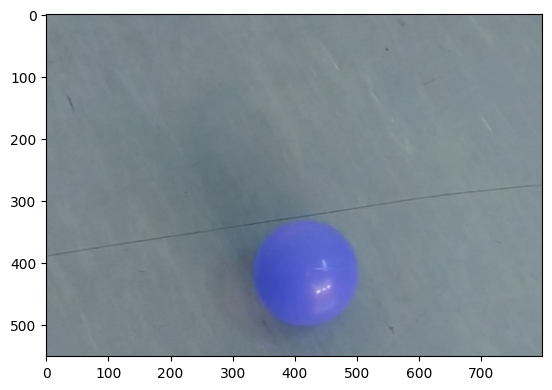

In [66]:
img_bgr = cv2.imread("ball.png")
plt.imshow(img_bgr)

## Detekcja piłki na zdjęciu

### Konwersja zdjęcia do HSV

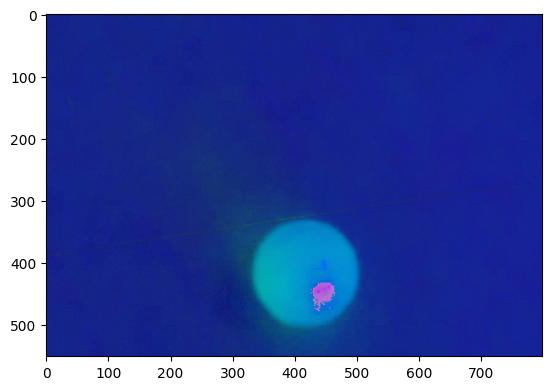

In [67]:
img_hsv = cv2.cvtColor(img_bgr.copy(), cv2.COLOR_BGR2HSV)
plt.imshow(img_hsv)

### Stworzenie maski dla detekcji kształtu piłki na podstawie koloru

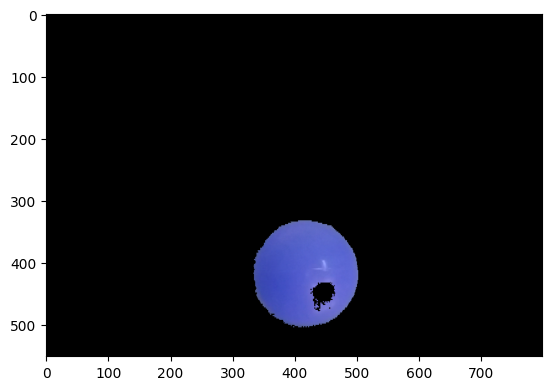

In [68]:
lower_bound = np.array([0, 0, 140], np.uint8)
upper_bound = np.array([5, 180, 255], np.uint8)
mask_ball = cv2.inRange(img_hsv, lower_bound, upper_bound)

masked_ball_hsv = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_ball)

plt.imshow(masked_ball_hsv)

### Usunięcie szumów z maski

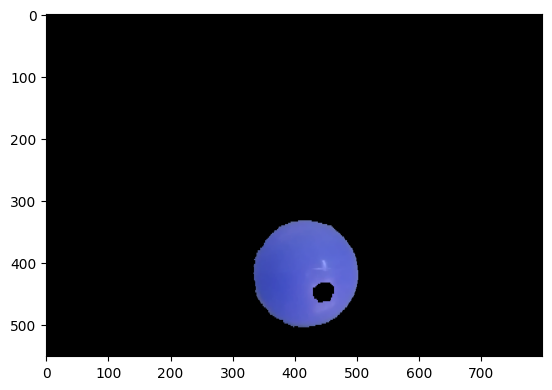

In [69]:
kernel = np.ones((5, 5), np.uint8)
mask_without_noise = cv2.morphologyEx(masked_ball_hsv, cv2.MORPH_CLOSE, kernel)

plt.imshow(mask_without_noise)

### Wyliczenie konturów piłki na zdjęciu

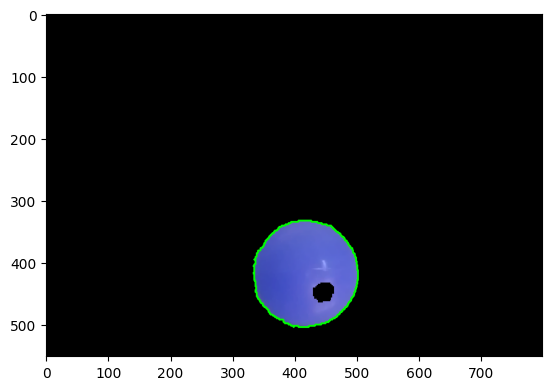

In [70]:
masked_binary = cv2.cvtColor(mask_without_noise, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(
    masked_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
img_conturs = mask_without_noise.copy()

for contour in contours:
    cv2.drawContours(img_conturs, [contour], 0, (0, 255, 0), 2)

plt.imshow(img_conturs)

### Wyznaczenie środka piłki

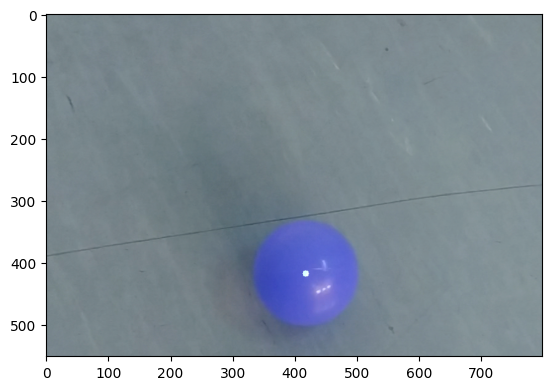

In [71]:
masked_binary = cv2.cvtColor(masked_ball_hsv.copy(), cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(
    masked_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

moments_of_img = cv2.moments(max(contours, key=cv2.contourArea))
center = (
    int(moments_of_img["m10"] / moments_of_img["m00"]),
    int(moments_of_img["m01"] / moments_of_img["m00"]),
)

point_color = (150, 255, 255)
center_point = cv2.circle(masked_ball_hsv, center, 5, point_color, -1)
img_bgr = cv2.bitwise_or(img_bgr, center_point)

plt.imshow(img_bgr)

### Ułożenie wszystkiego powyżej do postaci funkcji

In [72]:
def draw_center_point(img_bgr, lower_bound, upper_bound):
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # lower_bound = np.array([0, 0, 0], np.uint8)
    # upper_bound = np.array([4, 255, 255], np.uint8)
    main_mask = cv2.inRange(img_hsv, lower_bound, upper_bound)

    main_mask = cv2.dilate(main_mask, None, iterations=4)

    masked_hsv = cv2.bitwise_and(img_bgr, img_bgr, mask=main_mask)

    kernel = np.ones((5, 5), np.uint8)
    mask_without_noise = cv2.morphologyEx(masked_hsv, cv2.MORPH_CLOSE, kernel)

    masked_binary = cv2.cvtColor(mask_without_noise.copy(), cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(
        masked_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    moments_of_img = cv2.moments(max(contours, key=cv2.contourArea))
    center = (
        int(moments_of_img["m10"] / moments_of_img["m00"]),
        int(moments_of_img["m01"] / moments_of_img["m00"]),
    )

    point_color = (150, 255, 255)
    center_point = cv2.circle(masked_hsv, center, 5, point_color, -1)
    output = cv2.bitwise_or(img_bgr, center_point)

    return output

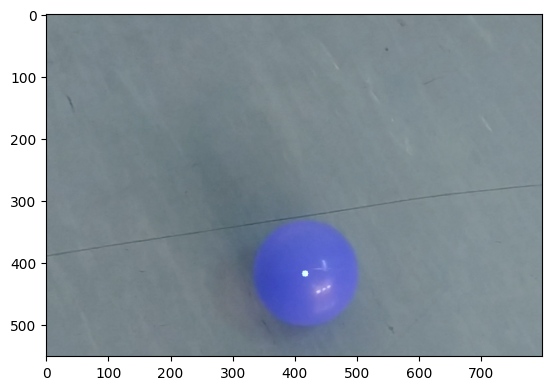

In [73]:
img_test = cv2.imread("ball.png")

lower_bound = np.array([0, 0, 0], np.uint8)
upper_bound = np.array([4, 255, 255], np.uint8)
plt.imshow(draw_center_point(img_test, lower_bound, upper_bound))

## Dla filmu movingball.mp4 Wykonaj śledzenie jak wyżej (dla każdej klatki filmu) i wygeneruj nowy film z oznaczeniem obiektu

In [74]:
moving_ball_path = "movingball.mp4"

lower_bound = np.array([0, 0, 0], np.uint8)
upper_bound = np.array([4, 255, 255], np.uint8)

In [85]:
from typing import Tuple


def process_video_and_save_output(
    video_path: str,
    proecess_fun=draw_center_point,
    output_path: str = "output_process.mp4",
    lower_bound: np.array = np.array([0, 0, 0], np.uint8),
    upper_bound: np.array = np.array([4, 255, 255], np.uint8),
    frame_size: Tuple = (1080, 1920),
    fps: float = 29.96,
):

    video_to_process = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(output_path, cv2.CAP_ANY, fourcc, fps, frame_size)
    frame_count = video_to_process.get(cv2.CAP_PROP_FRAME_COUNT)

    current_frame = 0
    while True:
        ret, frame = video_to_process.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        frame = proecess_fun(frame, lower_bound, upper_bound)
        out.write(frame)
        current_frame += 1

        if current_frame % 10 == 0:
            print(current_frame / frame_count)

    video_to_process.release()
    out.release()
    cv2.destroyAllWindows()

In [76]:
def mask_ball(
    img_bgr,
    lower_bound: np.array = np.array([0, 0, 0], np.uint8),
    upper_bound: np.array = np.array([4, 255, 255], np.uint8),
):


    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    main_mask = cv2.inRange(img_hsv, lower_bound, upper_bound)

    main_mask = cv2.dilate(main_mask, None, iterations=4)

    kernel = np.ones((7, 7), np.uint8)

    mask_without_noise = cv2.morphologyEx(main_mask, cv2.MORPH_OPEN, kernel)


    output = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_without_noise)

    return output

In [77]:
process_video_and_save_output(
    moving_ball_path, draw_center_point, "moving_ball_dotted.mp4"
)

0.01984126984126984
0.03968253968253968
0.05952380952380952
0.07936507936507936
0.0992063492063492
0.11904761904761904
0.1388888888888889
0.15873015873015872
0.17857142857142858
0.1984126984126984
0.21825396825396826
0.23809523809523808
0.25793650793650796
0.2777777777777778
0.2976190476190476
0.31746031746031744
0.3373015873015873
0.35714285714285715
0.376984126984127
0.3968253968253968
0.4166666666666667
0.4365079365079365
0.45634920634920634
0.47619047619047616
0.49603174603174605
0.5158730158730159
0.5357142857142857
0.5555555555555556
0.5753968253968254
0.5952380952380952
0.6150793650793651
0.6349206349206349
0.6547619047619048
0.6746031746031746
0.6944444444444444
0.7142857142857143
0.7341269841269841
0.753968253968254
0.7738095238095238
0.7936507936507936
0.8134920634920635
0.8333333333333334
0.8531746031746031
0.873015873015873
0.8928571428571429
0.9126984126984127
0.9325396825396826
0.9523809523809523
0.9722222222222222
0.9920634920634921
Can't receive frame (stream end?). Exi

In [78]:
process_video_and_save_output(moving_ball_path, mask_ball, "moving_ball_mask.mp4")

0.01984126984126984
0.03968253968253968
0.05952380952380952
0.07936507936507936
0.0992063492063492
0.11904761904761904
0.1388888888888889
0.15873015873015872
0.17857142857142858
0.1984126984126984
0.21825396825396826
0.23809523809523808
0.25793650793650796
0.2777777777777778
0.2976190476190476
0.31746031746031744
0.3373015873015873
0.35714285714285715
0.376984126984127
0.3968253968253968
0.4166666666666667
0.4365079365079365
0.45634920634920634
0.47619047619047616
0.49603174603174605
0.5158730158730159
0.5357142857142857
0.5555555555555556
0.5753968253968254
0.5952380952380952
0.6150793650793651
0.6349206349206349
0.6547619047619048
0.6746031746031746
0.6944444444444444
0.7142857142857143
0.7341269841269841
0.753968253968254
0.7738095238095238
0.7936507936507936
0.8134920634920635
0.8333333333333334
0.8531746031746031
0.873015873015873
0.8928571428571429
0.9126984126984127
0.9325396825396826
0.9523809523809523
0.9722222222222222
0.9920634920634921
Can't receive frame (stream end?). Exi

## Nagraj lub znajdź film z innym obiektem, określ jego barwę, i wygeneruj nowy film z zaznaczonym obiektem jak poprzednio piłkę

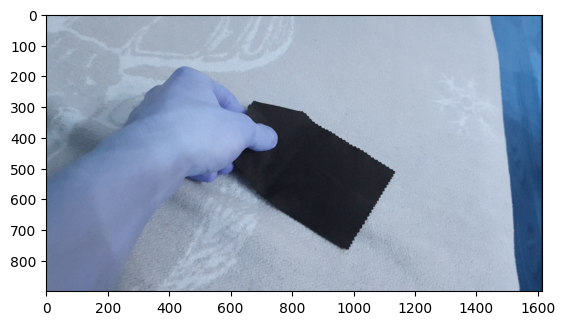

In [79]:
cloth_bgr = cv2.imread("cloth.png")
plt.imshow(cloth_bgr)

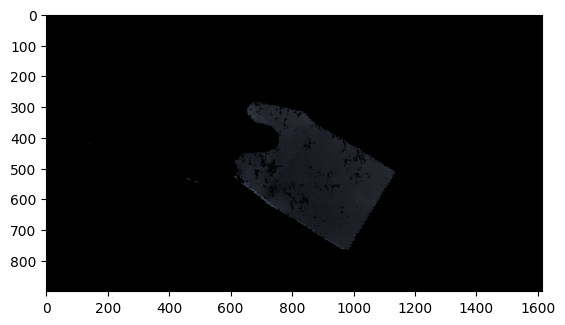

In [80]:
lower_bound_cloth = np.array([0, 0, 0], np.uint8)
upper_bound_cloth = np.array([15, 90, 100], np.uint8)
mask_cloth = cv2.inRange(cv2.cvtColor(cloth_bgr, cv2.COLOR_BGR2HSV), lower_bound_cloth, upper_bound_cloth)

masked_cloth_hsv = cv2.bitwise_and(cloth_bgr, cloth_bgr, mask=mask_cloth)

plt.imshow(masked_cloth_hsv)

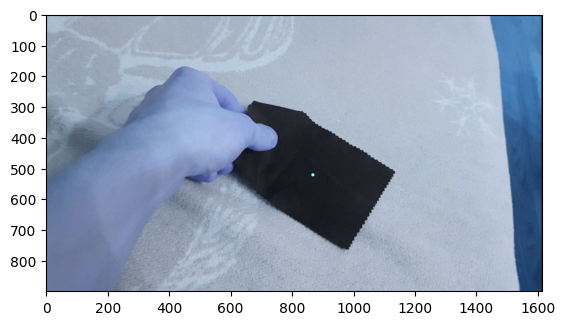

In [81]:
pointed_cloth = draw_center_point(cloth_bgr, lower_bound_cloth, upper_bound_cloth)
plt.imshow(pointed_cloth)

In [82]:
cloth_video_path = "black_cloth.mp4"

In [87]:
process_video_and_save_output(
    cloth_video_path,
    draw_center_point,
    "pointed_cloth_30.mp4",
    lower_bound_cloth,
    upper_bound_cloth,
    frame_size=(3840, 2160),
)

0.012376237623762377
0.024752475247524754
0.03712871287128713
0.04950495049504951
0.06188118811881188
0.07425742574257425
0.08663366336633663
0.09900990099009901
0.11138613861386139
0.12376237623762376
0.13613861386138615
0.1485148514851485
0.1608910891089109
0.17326732673267325
0.18564356435643564
0.19801980198019803
0.2103960396039604
0.22277227722772278
0.23514851485148514
0.24752475247524752
0.2599009900990099
0.2722772277227723
0.28465346534653463
0.297029702970297
0.3094059405940594
0.3217821782178218
0.3341584158415842
0.3465346534653465
0.3589108910891089
0.3712871287128713
0.38366336633663367
0.39603960396039606
0.4084158415841584
0.4207920792079208
0.43316831683168316
0.44554455445544555
0.45792079207920794
0.47029702970297027
0.48267326732673266
0.49504950495049505
0.5074257425742574
0.5198019801980198
0.5321782178217822
0.5445544554455446
0.556930693069307
0.5693069306930693
0.5816831683168316
0.594059405940594
0.6064356435643564
0.6188118811881188
0.6311881188118812
0.6435